In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from PIL import Image
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [2]:
%cd ./data/train/

/home/jupyter-deeplearning/Organize/data/train


In [3]:
def data_loader(files):
    out = []
    for file in tqdm(files):
        data = Image.open(file).convert('L')
        data = np.array(data,'uint8').reshape(-1)
        out.append(data)    
    out = np.array(out)
    return out

In [4]:
classes=sorted(glob("*"))

In [5]:
data_path=os.path.join(classes[0],"*.bmp")
data_path=glob(data_path)

In [6]:
train_data=np.zeros((1,96*96+1))
label_match=[]
for i,name in enumerate(classes):
    data_path=os.path.join(name,"*.bmp")
    data_path=glob(data_path)
    img_data=data_loader(data_path)
    img_data=np.insert(img_data, 0, i,axis=1)
    train_data=np.vstack([train_data,img_data])
    label_match.append([i,name])
train_data=np.delete(train_data,0,axis=0)

100%|██████████| 500/500 [00:00<00:00, 11282.35it/s]


In [7]:
print(label_match)

[[0, 'airplane'], [1, 'bird'], [2, 'car'], [3, 'cat'], [4, 'deer'], [5, 'dog'], [6, 'horse'], [7, 'monkey'], [8, 'ship'], [9, 'truck']]


In [8]:
# Data shuffle
np.take(train_data,np.random.permutation(train_data.shape[0]),
        axis=0,out=train_data)

array([[  4., 182., 187., ..., 194., 159., 167.],
       [  5.,  64.,  64., ...,  36.,  49.,  50.],
       [  0., 136., 135., ..., 105.,  98.,  94.],
       ...,
       [  2., 225., 224., ..., 255., 255., 255.],
       [  6., 133., 135., ..., 103., 118., 120.],
       [  3., 198., 198., ..., 123.,   7.,   0.]])

In [9]:
x_data=train_data[:,1:]
y_data=train_data[:,0]

In [10]:
# Data split
x_data_train, x_data_test, y_data_train, y_data_test = train_test_split(x_data, y_data, 
                                                                        test_size=0.2)

In [11]:
# Data normalization
# x_data_train=x_data_train/x_data_train.max()
# x_data_test=x_data_test/x_data_test.max()

In [12]:
class CustomDataset(Dataset):
    def __init__(self,x_dat,y_dat):
        x = x_dat
        y = y_dat
        self.len = x.shape[0]
        y=y.astype('int')
        x=x.astype('float32')
        self.x_data = torch.tensor(x)
        self.y_data = torch.tensor(y)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [13]:
batch_size=256
num_gpus=4
train_dataset = CustomDataset(x_data_train,y_data_train)
train_loader = DataLoader(dataset=train_dataset,pin_memory=True,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=60,drop_last=True)
test_dataset = CustomDataset(x_data_test,y_data_test)
test_loader = DataLoader(dataset=test_dataset,pin_memory=True,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=60,drop_last=True)

In [14]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [15]:
class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [16]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = x.view(batch_size//num_gpus,1,96,96)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(batch_size//num_gpus,-1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [17]:
model = ResNet(block=Bottleneck, layers=[3, 8, 36, 3])
model=nn.DataParallel(model.cuda())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=0.0001)

In [18]:
%cd /home/jupyter-deeplearning/res_model

/home/jupyter-deeplearning/res_model


In [19]:
trn_loss_list = []
val_loss_list = []
val_acc_list = []
total_epoch=200
model_char="minloss"
model_name=""
patience=5
start_early_stop_check=0
saving_start_epoch=10

for epoch in range(total_epoch):
    trn_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs=inputs.cuda()
            labels=labels.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        output= model(inputs)
        # calculate loss
        loss=criterion(output, labels)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del output
    with torch.no_grad():
        val_loss = 0.0
        cor_match = 0
        for j, val in enumerate(test_loader):
            val_x, val_label = val
            if torch.cuda.is_available():
                val_x = val_x.cuda()
                val_label =val_label.cuda()
            val_output = model(val_x)
            v_loss = criterion(val_output, val_label)
            val_loss += v_loss
            _, predicted=torch.max(val_output,1)
            cor_match+=np.count_nonzero(predicted.cpu().detach()==val_label.cpu().detach())
    del val_output
    del v_loss
    del predicted
    
    
    
    trn_loss_list.append(trn_loss/len(train_loader))
    val_loss_list.append(val_loss/len(test_loader))
    val_acc=cor_match/(len(test_loader)*batch_size)
    val_acc_list.append(val_acc)
    now = time.localtime()
    print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))

    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | val accuracy: {:.4f}% \n".format(
                epoch+1, total_epoch, trn_loss / len(train_loader), val_loss / len(test_loader), val_acc*100
            ))
    
    
    if epoch+1>2:
        if val_loss_list[-1]>val_loss_list[-2]:
            start_early_stop_check=1
    else:
        val_loss_min=val_loss_list[-1]
        
    if start_early_stop_check:
        early_stop_temp=val_loss_list[-patience:]
        if all(early_stop_temp[i]<early_stop_temp[i+1] for i in range (len(early_stop_temp)-1)):
            print("Early stop!")
            break
            
    if epoch+1>saving_start_epoch:
        if val_loss_list[-1]<val_loss_min:
            if os.path.isfile(model_name):
                os.remove(model_name)
            val_loss_min=val_loss_list[-1]
            model_name="Custom_model_"+model_char+"_{:.3f}".format(val_loss_min)
            torch.save(model, model_name)
            print("Model replaced and saved as ",model_name)

2020/10/28 13:58:09
epoch: 1/200 | trn loss: 2.9323 | val loss: 2.3465 | val accuracy: 16.5365% 

2020/10/28 13:58:23
epoch: 2/200 | trn loss: 2.2006 | val loss: 2.0783 | val accuracy: 24.2188% 

2020/10/28 13:58:36
epoch: 3/200 | trn loss: 1.9480 | val loss: 1.9349 | val accuracy: 26.3021% 

2020/10/28 13:58:50
epoch: 4/200 | trn loss: 1.7550 | val loss: 1.7387 | val accuracy: 34.5052% 

2020/10/28 13:59:04
epoch: 5/200 | trn loss: 1.6123 | val loss: 1.7776 | val accuracy: 35.0260% 

2020/10/28 13:59:17
epoch: 6/200 | trn loss: 1.4991 | val loss: 1.7311 | val accuracy: 34.5052% 

2020/10/28 13:59:31
epoch: 7/200 | trn loss: 1.3574 | val loss: 1.6974 | val accuracy: 36.5885% 

2020/10/28 13:59:45
epoch: 8/200 | trn loss: 1.2453 | val loss: 1.7006 | val accuracy: 36.4583% 

2020/10/28 13:59:59
epoch: 9/200 | trn loss: 1.1704 | val loss: 1.6778 | val accuracy: 39.1927% 

2020/10/28 14:00:12
epoch: 10/200 | trn loss: 1.0821 | val loss: 1.7873 | val accuracy: 39.4531% 

2020/10/28 14:00:26

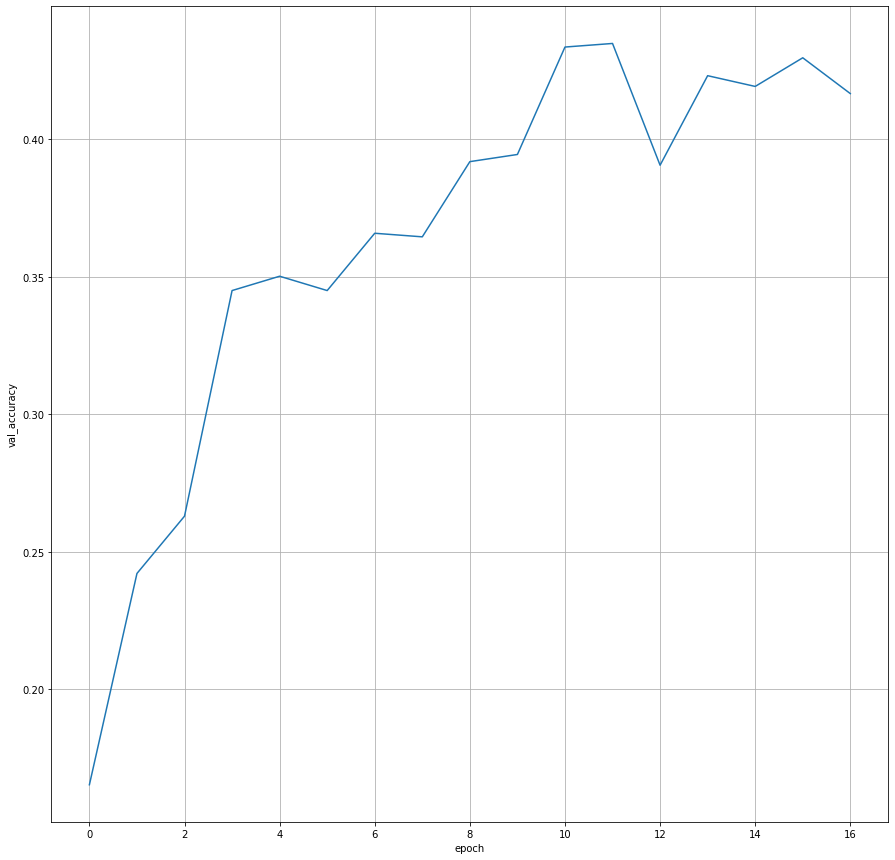

In [20]:
plt.figure(figsize=(15,15))
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.plot(val_acc_list)
plt.grid()

In [21]:
val_acc_list=np.array(val_acc_list)
np.savetxt("ver_1.1.txt", val_acc_list, delimiter=',')